In [3]:
#mengimport library
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [1]:
import matplotlib.pyplot as plt

# Digunakan untuk membuat plot dari metrik pelatihan dan validasi selama proses pelatihan model.
def plot_graphs(history, metric):
 # Plot metrik pelatihan
 plt.plot(history.history[metric])
 # Plot metrik validasi dengan garis putus-putus
 plt.plot(history.history['val_'+metric], '')
 # Tentukan label untuk sumbu-sumbu
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 # Tambahkan legenda ke plot
 plt.legend([metric, 'val_'+metric])


#### Setup input pipeline

In [4]:
# Memuat dataset IMDb reviews dari TensorFlow Datasets (tfds)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Membagi dataset menjadi bagian pelatihan dan pengujian
train_dataset, test_dataset = dataset['train'], dataset['test']

# Menampilkan spesifikasi elemen dari dataset pelatihan
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
  # Mencetak nilai tensor teks dari example
  print('text: ', example.numpy())

  # Mencetak nilai label dari example
  print('label: ', label.numpy())


text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Mengacak dan mengelompokkan dataset pelatihan
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Mengelompokkan dataset pengujian
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Mengambil satu batch dari dataset pelatihan
for example, label in train_dataset.take(1):
  # Mencetak tiga nilai tensor teks dari contoh pada batch pertama
  print('texts: ', example.numpy()[:3])
  print()
  # Mencetak tiga nilai label dari contoh pada batch pertama
  print('labels: ', label.numpy()[:3])


texts:  [b"Oh, where are you going, my little one, little one...<br /><br />Turn around and you're two, turn around and you're four...<br /><br />I remember these shows when they were first broadcast on Disneyland. I remember sitting there, electrified by Werner Van Braune's explanations of rocket science. I watched as history, science and humor were all interwoven in an engrossing story of possibilities.<br /><br />That was fifty years ago. And the shows are back in the Disney Treasures series, and what a treasure they are. I watched them last night and tonight with my 8 year old daughter, who at first would not even come in the room, but later changed her mind when she saw they were partly animated. As she watched I watched her, and by the end she was nearly as engrossed as I had been.<br /><br />Turn around and you're a young wife with babes of your own...<br /><br />Sure, some of the predictions about reaching the moon were wrong. But there is a lot of information that is still qui

#### Membuat Teks Encoder

In [7]:
VOCAB_SIZE = 1000

# Membuat layer TextVectorization dengan batas token maksimum
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# Menyesuaikan layer dengan dataset pelatihan untuk membangun kamus token
encoder.adapt(train_dataset.map(lambda text, label: text))


In [ ]:
vocab = np.array(encoder.get_vocabulary())

# Mencetak 20 token pertama dalam kamus
vocab[:20]


In [9]:
# Menggunakan encoder untuk mengkodekan tiga contoh teks dari batch pertama
encoded_example = encoder(example)[:3].numpy()

# Menampilkan hasil encoding
encoded_example


array([[452, 113,  24, ...,   0,   0,   0],
       [  7,   9,  41, ...,   0,   0,   0],
       [ 10, 139,  26, ...,   0,   0,   0]])

In [10]:
for n in range(3):
  # Mencetak teks asli dari tiga contoh pertama dalam batch
  print("Original: ", example[n].numpy())

  # Mencetak teks hasil putaran encoding-decoding
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()


Original:  b"Oh, where are you going, my little one, little one...<br /><br />Turn around and you're two, turn around and you're four...<br /><br />I remember these shows when they were first broadcast on Disneyland. I remember sitting there, electrified by Werner Van Braune's explanations of rocket science. I watched as history, science and humor were all interwoven in an engrossing story of possibilities.<br /><br />That was fifty years ago. And the shows are back in the Disney Treasures series, and what a treasure they are. I watched them last night and tonight with my 8 year old daughter, who at first would not even come in the room, but later changed her mind when she saw they were partly animated. As she watched I watched her, and by the end she was nearly as engrossed as I had been.<br /><br />Turn around and you're a young wife with babes of your own...<br /><br />Sure, some of the predictions about reaching the moon were wrong. But there is a lot of information that is still q

#### Membuat model

In [11]:
# Membuat model sequential dengan lapisan-lapisan yang ditentukan
model = tf.keras.Sequential([
    # Layer TextVectorization untuk mengubah teks menjadi urutan token
    encoder,

    # Layer Embedding untuk memetakan token ke dalam vektor-vektor
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Menggunakan masking untuk menghandle panjang urutan yang berbeda-beda
        mask_zero=True),

    # Lapisan Bidirectional LSTM untuk memproses urutan secara dua arah
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Lapisan Dense dengan fungsi aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Lapisan Dense akhir dengan satu unit untuk klasifikasi biner
    tf.keras.layers.Dense(1)
])


In [12]:
# Mencetak informasi apakah setiap lapisan dalam model mendukung masking
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


In [13]:
# Menggunakan model untuk membuat prediksi pada contoh teks
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi
print(predictions[0])


1/1 [==============================] - 8s 8s/step
[-0.01056339]


In [14]:
# Menyiapkan teks dengan padding yang panjang
padding = "the " * 2000

# Menggunakan model untuk membuat prediksi pada dua contoh teks
predictions = model.predict(np.array([sample_text, padding]))

# Mencetak hasil prediksi untuk contoh pertama
print(predictions[0])


1/1 [==============================] - 0s 63ms/step
[-0.01056339]


In [15]:
# Mengompilasi model dengan fungsi kerugian BinaryCrossentropy, optimizer Adam, dan metrik akurasi
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)


#### Train Model

In [16]:
# Melatih model dengan dataset pelatihan selama 10 epoch, menggunakan dataset validasi untuk evaluasi
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)


Epoch 1/10
391/391 [==============================] - 55s 114ms/step - loss: 0.6520 - accuracy: 0.5482 - val_loss: 0.5190 - val_accuracy: 0.7021
Epoch 2/10
391/391 [==============================] - 29s 74ms/step - loss: 0.5059 - accuracy: 0.7125 - val_loss: 0.4235 - val_accuracy: 0.7984
Epoch 3/10
391/391 [==============================] - 29s 74ms/step - loss: 0.3712 - accuracy: 0.8316 - val_loss: 0.3693 - val_accuracy: 0.8307
Epoch 4/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3395 - accuracy: 0.8483 - val_loss: 0.3527 - val_accuracy: 0.8490
Epoch 5/10
391/391 [==============================] - 31s 78ms/step - loss: 0.3236 - accuracy: 0.8575 - val_loss: 0.3381 - val_accuracy: 0.8469
Epoch 6/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3155 - accuracy: 0.8618 - val_loss: 0.3330 - val_accuracy: 0.8464
Epoch 7/10
391/391 [==============================] - 28s 72ms/step - loss: 0.3092 - accuracy: 0.8647 - val_loss: 0.3285 - val_accuracy

In [17]:
# Evaluasi model pada dataset pengujian
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak hasil evaluasi
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


391/391 [==============================] - 11s 28ms/step - loss: 0.3216 - accuracy: 0.8634
Test Loss: 0.3215887248516083
Test Accuracy: 0.8633599877357483


(0.0, 0.6695086106657981)

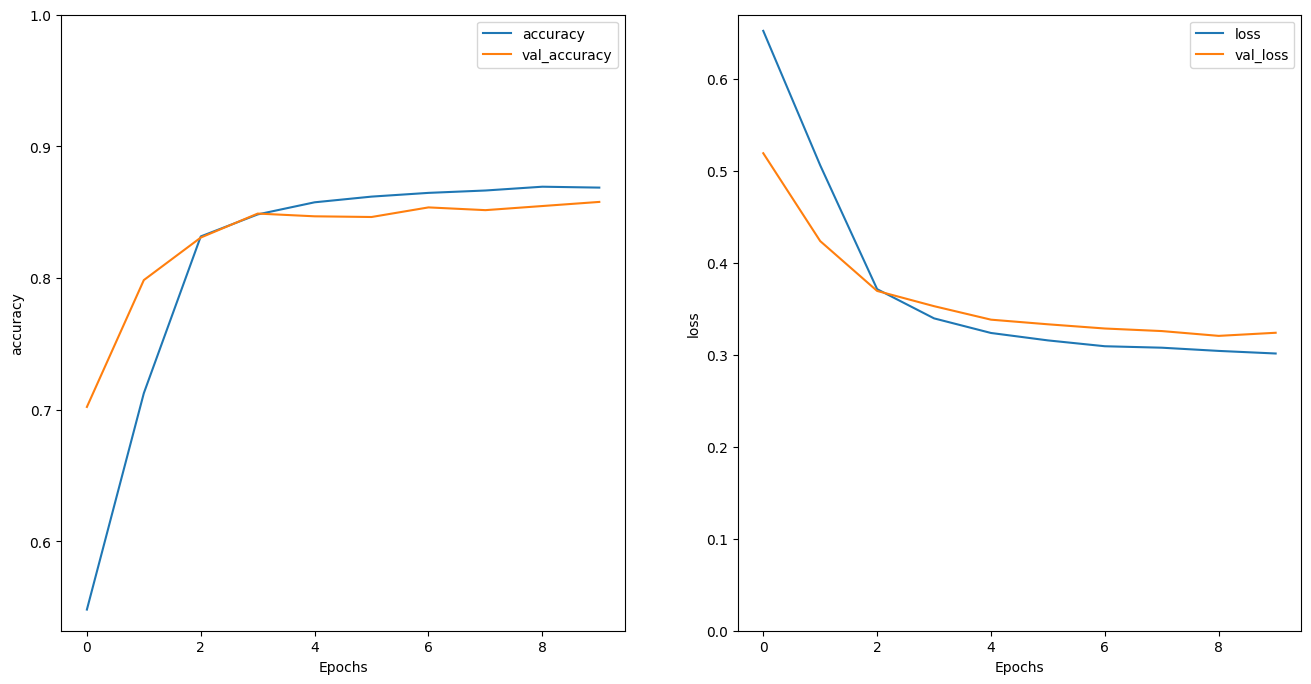

In [18]:
# Membuat gambar plot dengan ukuran 16x8
plt.figure(figsize=(16, 8))

# Membuat subplot pertama untuk plot akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)

# Membuat subplot kedua untuk plot kerugian
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [19]:
# Menggunakan model untuk membuat prediksi pada contoh teks
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))


1/1 [==============================] - 2s 2s/step


#### Stack two or more LSTM layers

In [20]:
# Membuat model sequential dengan lapisan-lapisan yang ditentukan
model = tf.keras.Sequential([
    # Layer TextVectorization untuk mengubah teks menjadi urutan token
    encoder,

    # Layer Embedding untuk memetakan token ke dalam vektor-vektor
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),

    # Lapisan Bidirectional LSTM pertama dengan return_sequences=True
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

    # Lapisan Bidirectional LSTM kedua
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    # Lapisan Dense dengan fungsi aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Lapisan Dropout untuk mengurangi overfitting
    tf.keras.layers.Dropout(0.5),

    # Lapisan Dense akhir dengan satu unit untuk klasifikasi biner
    tf.keras.layers.Dense(1)
])


In [21]:
# Mengompilasi model dengan fungsi kerugian BinaryCrossentropy, optimizer Adam, dan metrik akurasi
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)


In [22]:
# Melatih model dengan dataset pelatihan selama 10 epoch, menggunakan dataset validasi untuk evaluasi
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)


Epoch 1/10
391/391 [==============================] - 77s 150ms/step - loss: 0.6066 - accuracy: 0.6158 - val_loss: 0.4339 - val_accuracy: 0.8094
Epoch 2/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3882 - accuracy: 0.8265 - val_loss: 0.3557 - val_accuracy: 0.8286
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3360 - accuracy: 0.8554 - val_loss: 0.3410 - val_accuracy: 0.8297
Epoch 4/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3199 - accuracy: 0.8619 - val_loss: 0.3647 - val_accuracy: 0.8234
Epoch 5/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3127 - accuracy: 0.8661 - val_loss: 0.3263 - val_accuracy: 0.8495
Epoch 6/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3095 - accuracy: 0.8661 - val_loss: 0.3198 - val_accuracy: 0.8526
Epoch 7/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3036 - accuracy: 0.8711 - val_loss: 0.3276 - val_ac

In [23]:
# Evaluasi model pada dataset pengujian
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak hasil evaluasi
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


391/391 [==============================] - 19s 48ms/step - loss: 0.3153 - accuracy: 0.8576
Test Loss: 0.315346360206604
Test Accuracy: 0.8575999736785889


In [24]:
# Membuat prediksi pada contoh teks tanpa padding menggunakan model
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi
print(predictions)


1/1 [==============================] - 6s 6s/step
[[-1.6501884]]


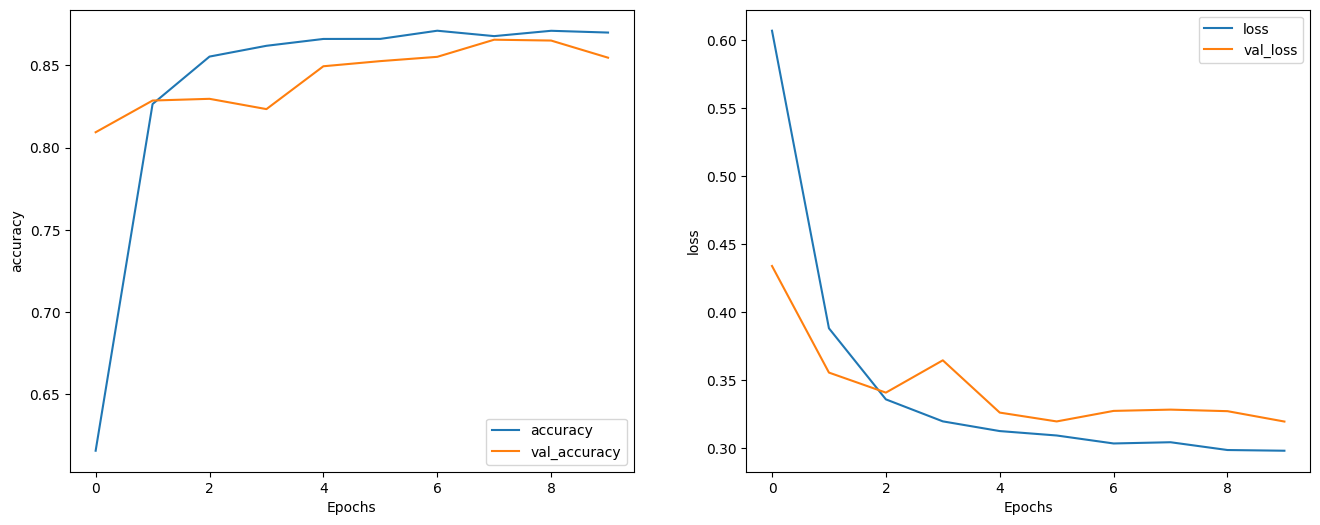

In [25]:
# Membuat gambar plot dengan ukuran 16x6
plt.figure(figsize=(16, 6))

# Membuat subplot pertama untuk plot akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')

# Membuat subplot kedua untuk plot kerugian
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
